# Developing Region-Specific Models to Determine Coral Presence
This notebook will walk through the process of developing models to classify Coral/Algae vs Other from our merged Coral datasets. It will contain the code to generate the final XGBoost models that we ultimately chose to use in practice for the Northern Caribbean/Florida/Bahamas region and the Great Barrier Reef Region.

Loading in necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Modeling Coral/Algae Presence with Allen Coral Data
Loading in our region-specific, combined coral datasets

In [64]:
allen_coral_car = pd.read_pickle('../data/merged_satellite_allen_mesoamerica.pkl')

## Developing Coral Presence Model for the Northern Caribbean, Florida, and Bahamas Region
We will start by cleaning up the data a bit and specifying the columns used in our analysis

In [67]:
allen_coral_car.replace(-100, np.nan, inplace=True)
allen_coral_car.dropna(inplace=True)
allen_coral_car.columns
allen_coral_car['class'].unique()
print(allen_coral_car.columns)

Index(['class', 'geometry', 'centroid_column', 'long', 'lat', 'sur_refl_b08',
       'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12',
       'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16', 'NDWI',
       'QA_PIXEL', 'Blue', 'Green', 'Red', 'Near Infrared',
       'Shortwave Infrared 1', 'Shortwave Infrared 2'],
      dtype='object')


In [68]:
coral_presence_cols = ['class','Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'NDWI']
allen_coral_car = allen_coral_car[coral_presence_cols]
allen_coral_car = allen_coral_car.dropna()
allen_coral_car['class'].unique()

array(['Coral/Algae', 'Non-Coral'], dtype=object)

Specifying the desired features and separating our target column

In [69]:
features = ['Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'NDWI']
X = allen_coral_car[features]
y = allen_coral_car['class']
y.replace("Non-Coral", 0, inplace=True)
y.replace("Coral/Algae", 1, inplace=True)
print(y.unique())

[1 0]


C:\Users\Danielle\AppData\Local\Temp\ipykernel_64672\332704852.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace("Coral/Algae", 1, inplace=True)


Splitting the data into train, validation and test. This is **not** a temporal train/test split because the coral/algae model is time-agnostic because labels are not time-stamped

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=48)
X_train = X_train.values
X_valid = X_valid.values
X_test = X_test.values

In [71]:
print(y_train.unique())

[1 0]


Training XGBoost Classifier to identify Coral/Algae for the Caribbean Region

In [72]:
#!pip install xgboost
import xgboost as xgb
xgb_caribbean = xgb.XGBClassifier(objective="binary:logistic", random_state=111, reg_alpha=.5, reg_lambda=.5, max_depth=15, n_estimators=400, learning_rate=0.1)
xgb_caribbean.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...)

Scoring the model on the validation set

In [73]:
xgb_caribbean.score(X_valid, y_valid)

0.9929221435793731

Saving the model to Pickle

In [74]:
pickle.dump(xgb_caribbean, open("./coral_presence_xgb_model_CAR_10km.pkl", "wb"))

Looking at ROC/AUC, Confusion Matrix, and Feature Importance for the Caribbean Coral/Algae Model

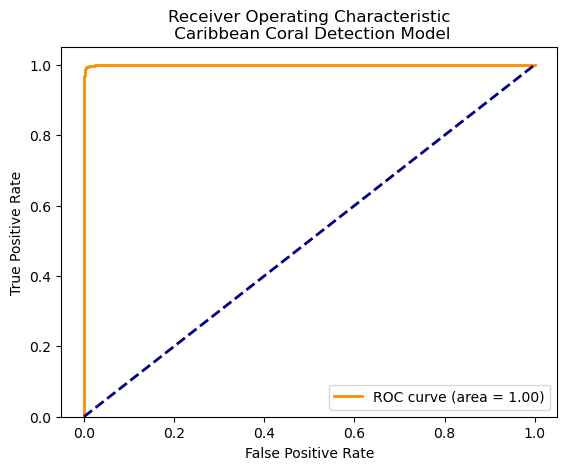

In [75]:
# plotting roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = xgb_caribbean.predict_proba(X_valid)[:, 1]
fpr, tpr, _ = roc_curve(y_valid, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic\n Caribbean Coral Detection Model')
plt.legend(loc="lower right")
plt.show()


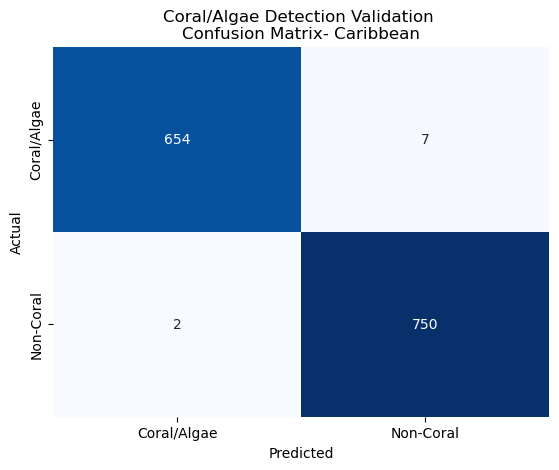

In [76]:
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = xgb_caribbean.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Coral/Algae", "Non-Coral"], yticklabels=["Coral/Algae", "Non-Coral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Coral/Algae Detection Validation \nConfusion Matrix- Caribbean')
plt.show()

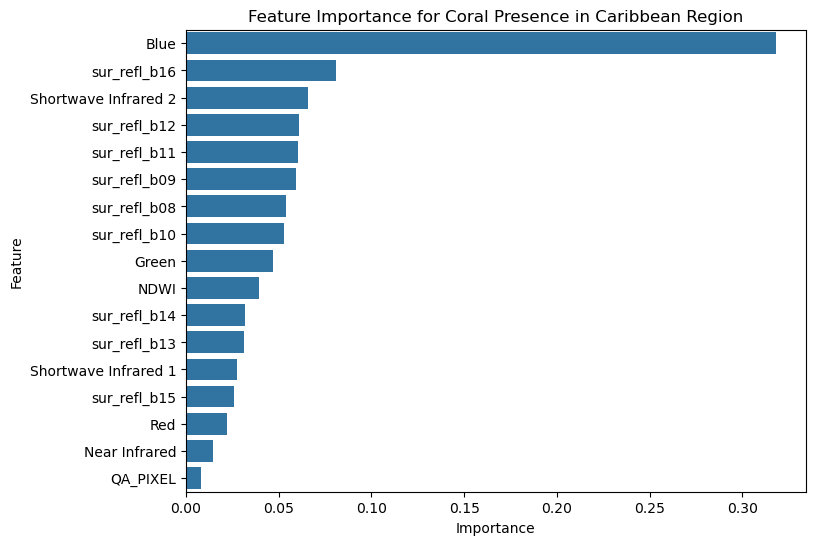

In [77]:
importance = xgb_caribbean.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Coral Presence in Caribbean Region')
plt.show()

## Training Great Barrier Reef Region Coral Presence Model

In [99]:
allen_coral = pd.read_pickle('./landsat_modis_allen_spectral_50k.pkl')

In [100]:
coral_presence_cols = ['Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'NDVI', 'NDWI', 'class']
allen_coral = allen_coral[coral_presence_cols]
allen_coral = allen_coral.dropna()

In [101]:
allen_coral['class'].value_counts()

Non-Coral    24501
Coral        21573
Name: class, dtype: int64

Specifying the desired features and separating our target column

In [102]:
features = ['Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16']
X = allen_coral[features]
y = allen_coral['class']
y.replace("Non-Coral", 0, inplace=True)
y.replace("Coral", 1, inplace=True)

Splitting the data into train, validation and test. This is **not** a temporal train/test split because the coral/algae model is time-agnostic because labels are not time-stamped

In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train = X_train.values
X_valid = X_valid.values
X_test = X_test.values

Training XGBoost Classifier to identify Coral/Algae for the GBR Region

In [106]:
import xgboost as xgb
xgb_gbr = xgb.XGBClassifier(objective="binary:logistic", random_state=111, reg_alpha=.5, reg_lambda=.5, max_depth=15, n_estimators=400, learning_rate=0.1)
xgb_gbr.fit(X_train, y_train)

/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:23:07] WARNING: /Users/patrickgeitner/xgboost-1.4.2/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=1, num_parallel_tree=1, random_state=111,
              reg_alpha=0.5, reg_lambda=0.5, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Scoring the model on the validation set

In [107]:
xgb_gbr.score(X_valid, y_valid)

0.9654096581660336

Saving the model to Pickle

In [108]:
pickle.dump(xgb_gbr, open("./coral_presence_xgb_model_GBR_10km.pkl", "wb"))

Looking at ROC/AUC, Confusion Matrix, and Feature Importance for the GBR Region

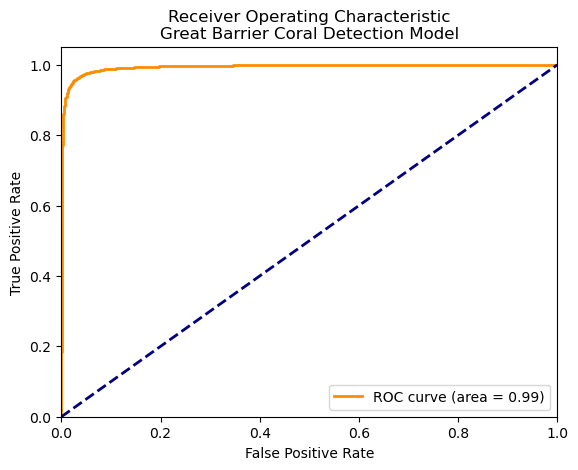

In [109]:
# plotting roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = xgb_gbr.predict_proba(X_valid)[:, 1]
fpr, tpr, _ = roc_curve(y_valid, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic\nGreat Barrier Coral Detection Model')
plt.legend(loc="lower right")
plt.show()


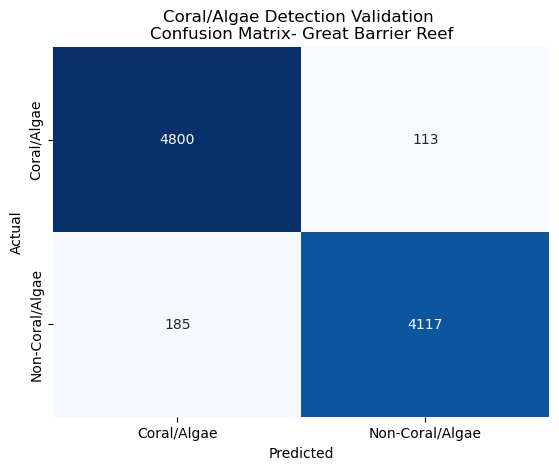

In [110]:
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = xgb_gbr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Coral/Algae", "Non-Coral/Algae"], yticklabels=["Coral/Algae", "Non-Coral/Algae"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Coral/Algae Detection Validation \nConfusion Matrix- Great Barrier Reef')
plt.show()

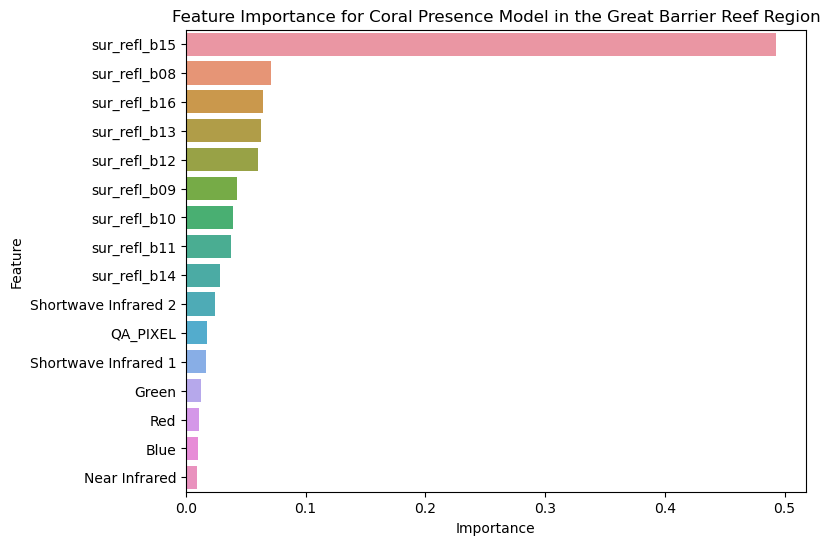

In [111]:
importance = xgb_gbr.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Coral Presence Model in the Great Barrier Reef Region')
plt.show()

## Summarized Accuracy Table

| Region | Accuracy |
| --- | --- |
| Northern Caribbean, Florida, and Bahamas | 84.6% |
| Great Barrier Reef | 96.5% |